# Malaria Detection with Raspberry Pi Zero 2W

## Objectives:

Automating the process of detecting Malaria with deep learning aims to provide a rapid, accurate, and accessible diagnostic tool. This technological leap would enable quicker treatment, reduce the burden on healthcare systems, and improve patient outcomes, ultimately saving countless lives by making early and reliable diagnosis available to even the most remote and underserved populations.

## Important Considerations:

- This is just a Proof of Concept project, it needs to be adapted to a specific microscope to work properly.
- It is important to make this product as cheap as possible since Malaria affects mostly under developed countries.
- We need a way to pre-process our data in order to use it as input to the model.

## Imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile
import os
import kagglehub
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import cv2
import random
import glob
import shutil

/Users/rolds/Documents/venvs/Malaria_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import tensorflow as tf
from tensorflow.keras import backend, Model
from tensorflow.keras.applications.vgg16 import VGG16

## Dataset:

### Description:

The dataset that was used was: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria

There are a total of 27560 images (colored) that we have taken from microscopic images. These images are of the following categories:

- Parasitized: The parasitized cells contain the Plasmodium parasite which causes malaria
- Uninfected: The uninfected cells are free of the Plasmodium parasites

### Download the Dataset:

In [3]:
try:
    dataset_path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

except Exception as e:
    print(f"Falha ao baixar o dataset: {e}")

In [4]:
print(dataset_path)

/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1


### Preparing the Dataset:

In [5]:
for i in os.listdir(os.path.join(dataset_path, 'cell_images')):
    print(i)

.DS_Store
Parasitized
Uninfected
cell_images


In [6]:
parasitized_path = os.path.join(dataset_path, 'cell_images', 'Parasitized')
uninfected_path = os.path.join(dataset_path, 'cell_images', 'Uninfected')

In [7]:
len(os.listdir(parasitized_path)), len(os.listdir(uninfected_path))

(13780, 13780)

In [8]:
parasitized_files = glob.glob(os.path.join(parasitized_path, '*.png'))
uninfected_files = glob.glob(os.path.join(uninfected_path, '*.png'))

In [9]:
parasitized_files[:5]

['/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized/C118P79ThinF_IMG_20151002_105018_cell_150.png',
 '/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized/C189P150ThinF_IMG_20151203_142224_cell_84.png',
 '/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized/C91P52ThinF_IMG_20150821_123116_cell_189.png',
 '/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized/C84P45ThinF_IMG_20150818_101226_cell_98.png',
 '/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized/C144P105ThinF_IMG_20151015_163432_cell_310.png']

In [10]:
uninfected_files[:5]

['/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Uninfected/C13NThinF_IMG_20150614_131318_cell_179.png',
 '/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Uninfected/C205ThinF_IMG_20151106_152003_cell_21.png',
 '/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Uninfected/C230ThinF_IMG_20151112_150647_cell_1.png',
 '/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Uninfected/C134P95ThinF_IMG_20151005_121834_cell_65.png',
 '/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Uninfected/C141P102ThinF_IMG_20151005_214836_cell_132.png']

In [11]:
len(parasitized_files), len(uninfected_files)

(13779, 13779)

In [12]:
temp = parasitized_files + uninfected_files
y_temp = [1] * len(parasitized_files) + [0] * len(uninfected_files)

In [13]:
len(temp), len(y_temp)

(27558, 27558)

In [14]:
temp[0]

'/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized/C118P79ThinF_IMG_20151002_105018_cell_150.png'

In [15]:
image_size = (64, 64)

for i in range(len(temp)):
    img = cv2.imread(temp[i])
    img = cv2.resize(img, image_size)
    temp[i] = [img, y_temp[i]]

In [16]:
temp[0][0].shape, temp[0][1]

((64, 64, 3), 1)

In [17]:
for i in range(10):
    print(temp[i][0].shape, temp[i][1])

(64, 64, 3) 1
(64, 64, 3) 1
(64, 64, 3) 1
(64, 64, 3) 1
(64, 64, 3) 1
(64, 64, 3) 1
(64, 64, 3) 1
(64, 64, 3) 1
(64, 64, 3) 1
(64, 64, 3) 1


In [18]:
for i in range(10):
    print(temp[len(temp)-1-i][0].shape, temp[len(temp)-1-i][1])

(64, 64, 3) 0
(64, 64, 3) 0
(64, 64, 3) 0
(64, 64, 3) 0
(64, 64, 3) 0
(64, 64, 3) 0
(64, 64, 3) 0
(64, 64, 3) 0
(64, 64, 3) 0
(64, 64, 3) 0


In [19]:
X = np.array([item[0] for item in temp])
y = np.array([item[1] for item in temp])

In [20]:
X.shape, y.shape

((27558, 64, 64, 3), (27558,))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de X_test: {X_test.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Shape de y_test: {y_test.shape}")

Shape de X_train: (22046, 64, 64, 3)
Shape de X_test: (5512, 64, 64, 3)
Shape de y_train: (22046,)
Shape de y_test: (5512,)


### Visualizing Samples:

1


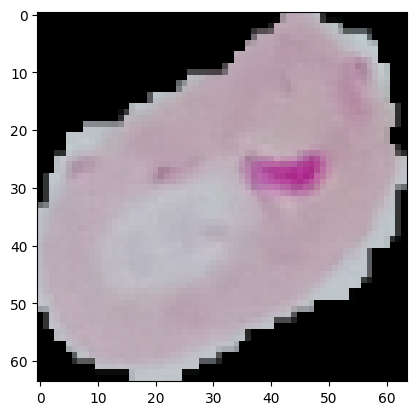

In [23]:
plt.imshow(X_train[0])
print(y_train[0])

1


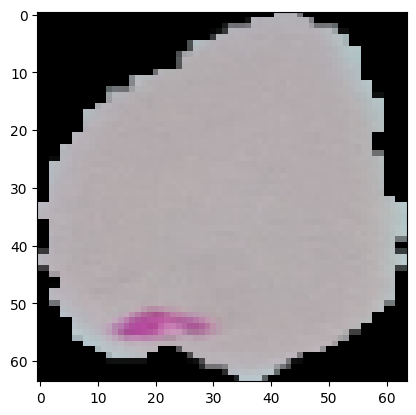

In [24]:
plt.imshow(X_train[4])
print(y_train[4])

1


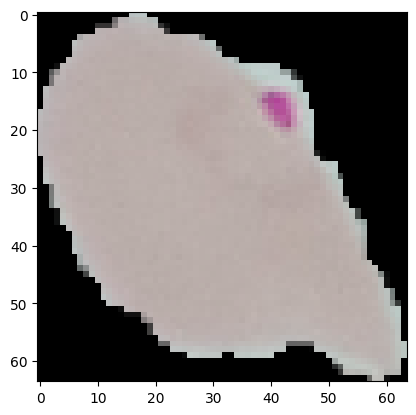

In [25]:
plt.imshow(X_test[0])
print(y_test[0])

1


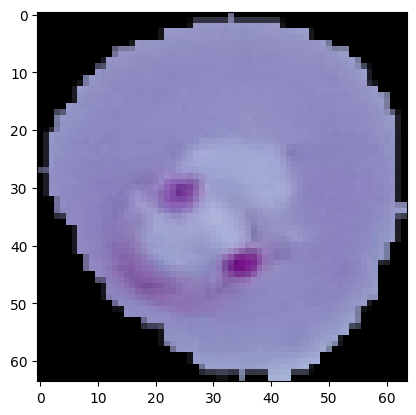

In [26]:
plt.imshow(X_test[1])
print(y_test[1])

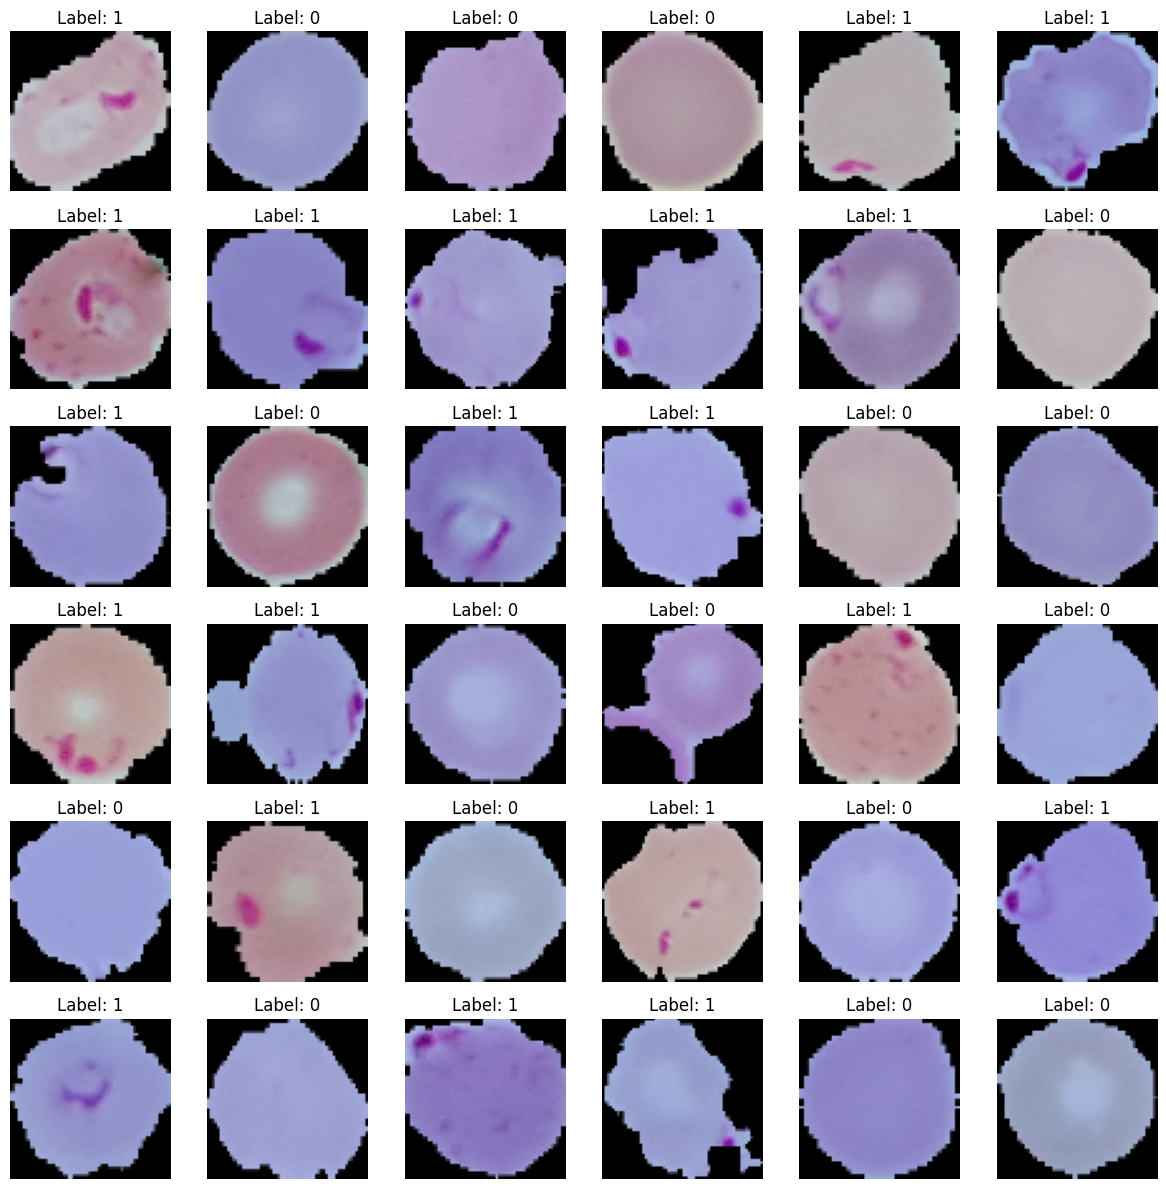

In [27]:
plt.figure(figsize=(12, 12))

for i in range(18):
    plt.subplot(6, 6, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

for i in range(18):
    plt.subplot(6, 6, 18 + i + 1)
    plt.imshow(X_train[-(18 - i)])
    plt.title(f"Label: {y_train[-(18 - i)]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Checking the Distribution:

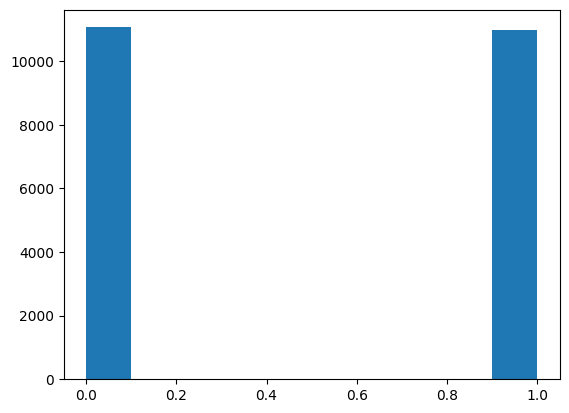

In [28]:
plt.hist(y_train)
plt.show()

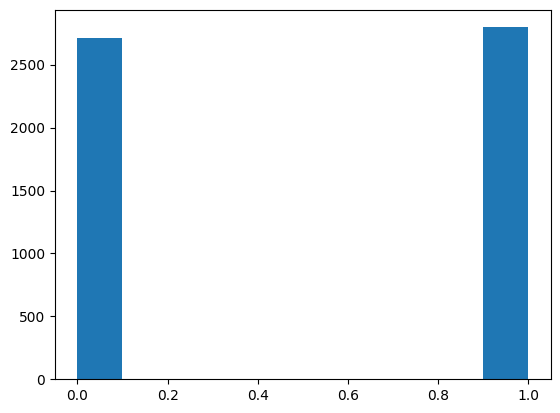

In [29]:
plt.hist(y_test)
plt.show()

### Normalizing the Data:

In [30]:
print("Training data range:", np.min(X_train.flatten()), "-", np.max(X_train.flatten()))
print("Testing data range:", np.min(X_test.flatten()), "-", np.max(X_test.flatten()))

Training data range: 0 - 255
Testing data range: 0 - 255


In [31]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [32]:
print("Training data range:", np.min(X_train.flatten()), "-", np.max(X_train.flatten()))
print("Testing data range:", np.min(X_test.flatten()), "-", np.max(X_test.flatten()))

Training data range: 0.0 - 1.0
Testing data range: 0.0 - 1.0


### Data Augmentation:

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 30
)

val_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 30
)

train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size = 64, seed = 42, shuffle = True)

val_generator =  val_datagen.flow(x = X_val, y = y_val, batch_size = 64, seed = 42, shuffle = True)

In [34]:
print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de X_val: {X_val.shape}")
print(f"Shape de X_test: {X_test.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Shape de y_val: {y_val.shape}")
print(f"Shape de y_test: {y_test.shape}")

Shape de X_train: (15432, 64, 64, 3)
Shape de X_val: (6614, 64, 64, 3)
Shape de X_test: (5512, 64, 64, 3)
Shape de y_train: (15432,)
Shape de y_val: (6614,)
Shape de y_test: (5512,)


In [35]:
print("Shape of a batch of images from train_generator:", train_generator[0][0].shape)

Shape of a batch of images from train_generator: (64, 64, 64, 3)


In [36]:
train_generator

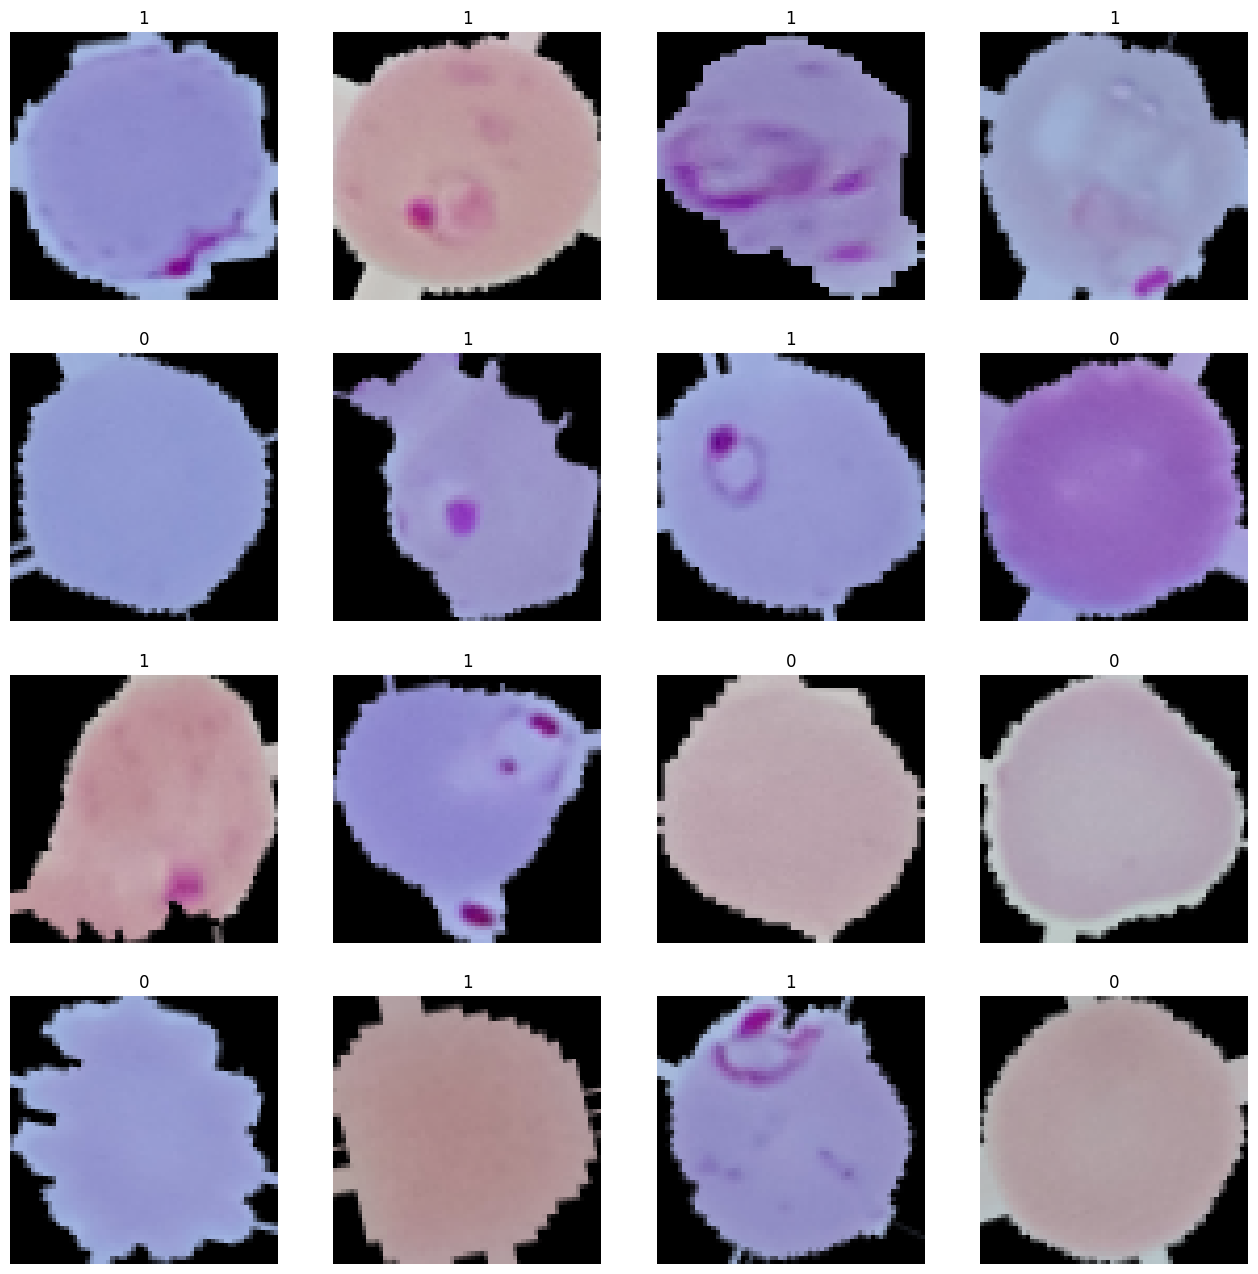

In [37]:
images, labels = next(train_generator)

fig, axes = plt.subplots(4, 4, figsize = (16, 8))

fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):

    ax.imshow(image)

    if label == 1:
        ax.set_title('1')
    else:
        ax.set_title('0')

    ax.axis('off')

## Feature testing:

### Converting RGB to HSV of Images using OpenCV:

### Gaussian Blurring:

## Model Development:

In [38]:
def plot_accuracy(history):
    N = len(history.history["accuracy"])

    plt.figure(figsize = (7, 7))
    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--')
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

### Standart Images:

#### Model 0:

In [39]:
backend.clear_session()

In [40]:
model_std_0 = tf.keras.models.Sequential()

model_std_0.add(tf.keras.layers.InputLayer((64, 64, 3)))
model_std_0.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = "relu"))
model_std_0.add(tf.keras.layers.MaxPooling2D(pool_size = 2))
model_std_0.add(tf.keras.layers.Dropout(0.2))
model_std_0.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"))
model_std_0.add(tf.keras.layers.MaxPooling2D(pool_size = 2))
model_std_0.add(tf.keras.layers.Dropout(0.2))
model_std_0.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"))
model_std_0.add(tf.keras.layers.MaxPooling2D(pool_size = 2))
model_std_0.add(tf.keras.layers.Dropout(0.2))
model_std_0.add(tf.keras.layers.Flatten())
model_std_0.add(tf.keras.layers.Dense(256, activation = "relu"))
model_std_0.add(tf.keras.layers.Dropout(0.3))
model_std_0.add(tf.keras.layers.Dense(1, activation = "sigmoid"))

model_std_0.summary()

2025-11-05 19:25:04.147910: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-11-05 19:25:04.147932: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-11-05 19:25:04.147938: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 14.04 GB
2025-11-05 19:25:04.147951: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-05 19:25:04.147960: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,105,409 (4.22 MB)

 Trainable params: 1,105,409 (4.22 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model_std_0.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [42]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('../Projects/Malaria-Detection-on-Raspberry-Pi-Zero-2W/models/best_model_std_0.keras', save_best_only=True, monitor='val_loss')
]

In [43]:
steps_per_epoch = len(X_train) // 64
validation_steps = len(X_val) // 64

history = model_std_0.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

/Users/rolds/Documents/venvs/Malaria_venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


2025-11-05 19:25:04.556032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


241/241 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.5503 - loss: 0.7027 - val_accuracy: 0.7693 - val_loss: 0.5452
Epoch 2/100
  1/241 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7656 - loss: 0.5874

/Users/rolds/Documents/venvs/Malaria_venv/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7656 - loss: 0.5874 - val_accuracy: 0.7652 - val_loss: 0.5358
Epoch 3/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8378 - loss: 0.4798 - val_accuracy: 0.9331 - val_loss: 0.2079
Epoch 4/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9375 - loss: 0.1782 - val_accuracy: 0.9328 - val_loss: 0.2111
Epoch 5/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9277 - loss: 0.2469 - val_accuracy: 0.9543 - val_loss: 0.1778
Epoch 6/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9531 - loss: 0.1486 - val_accuracy: 0.9492 - val_loss: 0.2020
Epoch 7/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9340 - loss: 0.2034 - val_accuracy: 0.9370 - val_loss: 0.1794
Epoch 8/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9219 - loss: 0.2533 - val_accuracy: 0.9384 - val_loss: 0.1820


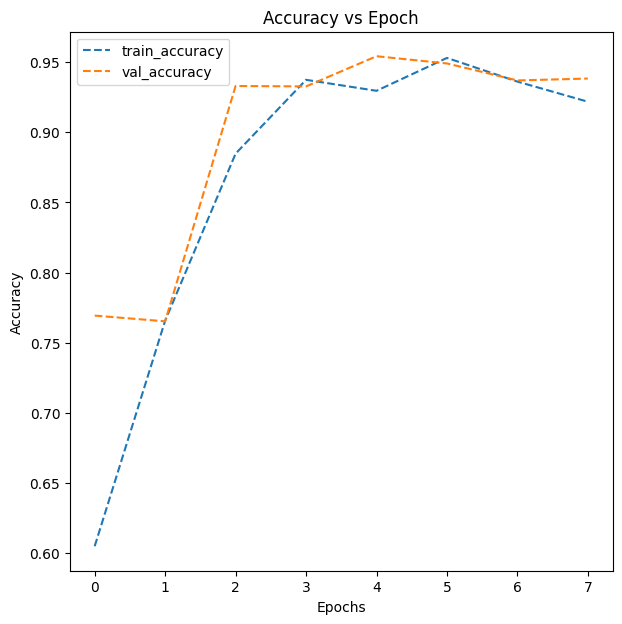

In [56]:
plot_accuracy(history)

In [45]:
accuracy = model_std_0.evaluate(X_test, y_test, verbose = 1)

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9535 - loss: 0.1552


In [59]:
pred_prob = model_std_0.predict(X_test)
pred_classes = (pred_prob > 0.3).astype("int32")

print(classification_report(y_test, pred_classes))

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2715
           1       0.95      0.95      0.95      2797

    accuracy                           0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512



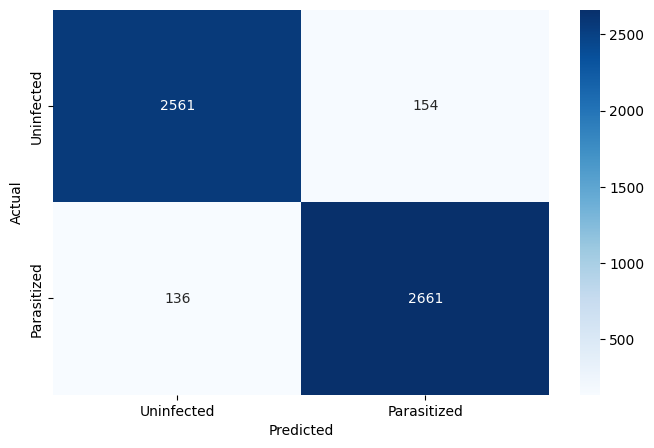

In [60]:
cm = confusion_matrix(y_test, pred_classes)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'], cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Model 1:

In [61]:
backend.clear_session()

In [62]:
model_std_1 = tf.keras.models.Sequential()

model_std_1.add(tf.keras.layers.InputLayer((64, 64, 3)))
model_std_1.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 2, padding = "same"))
model_std_1.add(tf.keras.layers.LeakyReLU(alpha=0.1))
model_std_1.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same'))
model_std_1.add(tf.keras.layers.LeakyReLU(alpha=0.1))
model_std_1.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_std_1.add(tf.keras.layers.BatchNormalization())
model_std_1.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same'))
model_std_1.add(tf.keras.layers.LeakyReLU(alpha=0.1))
model_std_1.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
model_std_1.add(tf.keras.layers.LeakyReLU(alpha=0.1))
model_std_1.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_std_1.add(tf.keras.layers.BatchNormalization())
model_std_1.add(tf.keras.layers.Flatten())
model_std_1.add(tf.keras.layers.Dense(32))
model_std_1.add(tf.keras.layers.LeakyReLU(alpha=0.1))
model_std_1.add(tf.keras.layers.Dropout(0.5))
model_std_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_std_1.summary()

/Users/rolds/Documents/venvs/Malaria_venv/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       524,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 571,777 (2.18 MB)

 Trainable params: 571,585 (2.18 MB)

 Non-trainable params: 192 (768.00 B)

In [63]:
model_std_1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [64]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('../Projects/Malaria-Detection-on-Raspberry-Pi-Zero-2W/models/best_model_std_1.keras', save_best_only=True, monitor='val_loss')
]

In [65]:
steps_per_epoch = len(X_train) // 64
validation_steps = len(X_val) // 64

history = model_std_1.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.5966 - loss: 1.0694 - val_accuracy: 0.5408 - val_loss: 1.9050
Epoch 2/100
  1/241 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8594 - loss: 0.4059

/Users/rolds/Documents/venvs/Malaria_venv/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8594 - loss: 0.4059 - val_accuracy: 0.5391 - val_loss: 1.7217
Epoch 3/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8867 - loss: 0.3126 - val_accuracy: 0.8316 - val_loss: 0.5706
Epoch 4/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8906 - loss: 0.3497 - val_accuracy: 0.8070 - val_loss: 0.6437
Epoch 5/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9351 - loss: 0.2119 - val_accuracy: 0.8215 - val_loss: 0.3825
Epoch 6/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9062 - loss: 0.2918 - val_accuracy: 0.8143 - val_loss: 0.4026
Epoch 7/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9372 - loss: 0.1874 - val_accuracy: 0.9446 - val_loss: 0.1603
Epoch 8/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9375 - loss: 0.1802 - val_accuracy: 0.9465 - val_loss: 0.1623
Epoch 9/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9424 - loss: 0.1715 - val_accuracy: 0.

In [66]:
accuracy = model_std_1.evaluate(X_test, y_test, verbose = 1)

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9428 - loss: 0.1610


In [67]:
pred_prob = model_std_1.predict(X_test)
pred_classes = (pred_prob > 0.3).astype("int32")

print(classification_report(y_test, pred_classes))

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2715
           1       0.94      0.95      0.95      2797

    accuracy                           0.95      5512
   macro avg       0.95      0.94      0.95      5512
weighted avg       0.95      0.95      0.95      5512



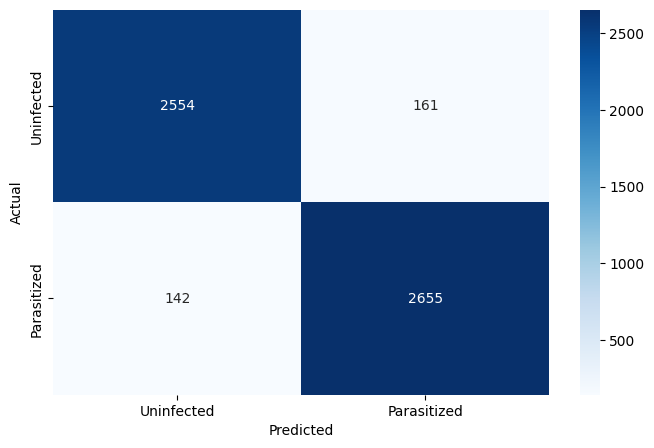

In [68]:
cm = confusion_matrix(y_test, pred_classes)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'], cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### HSV:

### Gaussian Blurring: